# Rating Profiles
## Network Analysis - University of Helsinki
* Teemu Koivisto (teemu.koivisto@helsinki.fi)
* Tomáš Vopat (tomas.vopat@helsinki.fi)

Dataset: http://www.occamslab.com/petricek/data/

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# paths to data files
PATH_RATINGS = "data/ratings.csv"
PATH_GENDER = "data/gender.dat"
PATH_GRAPH = "data/graph.gexf"

In [3]:
#ratings = pd.read_csv(PATH_RATINGS, names=['rater', 'rated', 'rating'])
ratings = pd.read_csv(PATH_RATINGS)
gender = pd.read_csv(PATH_GENDER, names=['node', 'gender'])

In [4]:
degrees = pd.Series(ratings.groupby('source')['target'].nunique(), name="degree")

joined = pd.merge(ratings, gender, left_on='source', right_on='node').drop(columns="node")
joined = pd.merge(joined, degrees, on='source')

In [5]:
female = joined[joined['gender'] == 'M']
male = joined[joined['gender'] == 'F']
unknown = joined[joined['gender'] == 'U']

In [6]:
ratings.head(5)

,source,target,weight
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [7]:
gender.head(5)

,node,gender
0,1,F
1,2,F
2,3,U
3,4,F
4,5,F


In [8]:
joined.head(5)

,source,target,weight,gender,degree
0,1,133,8,F,345
1,1,720,6,F,345
2,1,971,10,F,345
3,1,1095,7,F,345
4,1,1616,10,F,345


In [9]:
print('total edges', len(ratings))
print('of which are female', len(female))
print('and male', len(male))
print('and unknown', len(unknown))
print('total nodes', len(gender))

total edges 17359346
of which are female 4852458
and male 10804043
and unknown 1702845
total nodes 220970


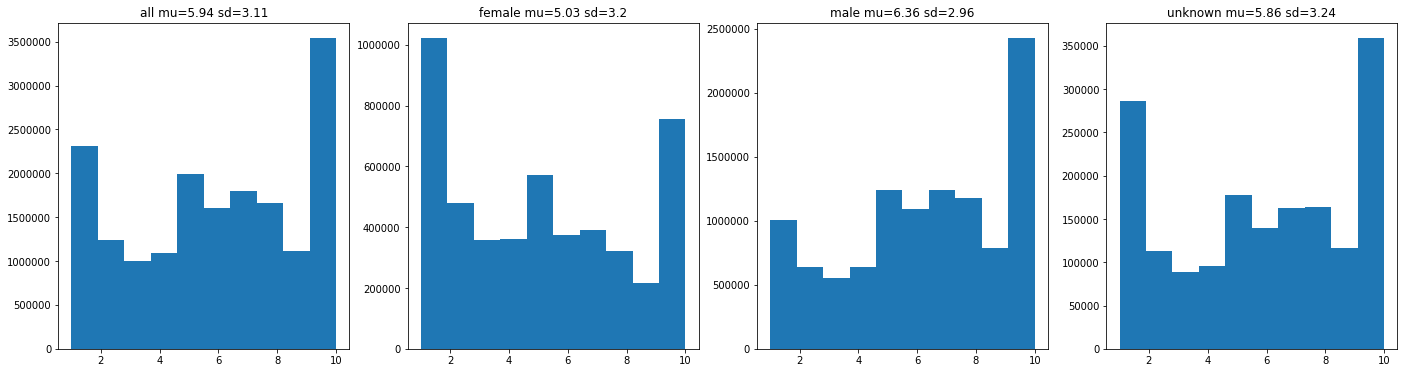

In [10]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

def get_title(name, df):
    mu = np.round(df["weight"].mean(), 2)
    sd = np.round(df["weight"].std(), 2)
    return f"{name} mu={mu} sd={sd}"

ax[0].hist(joined["weight"], bins=10)
ax[0].set_title(get_title('all', joined))
ax[1].hist(female["weight"], bins=10)
ax[1].set_title(get_title('female', female))
ax[2].hist(male["weight"], bins=10)
ax[2].set_title(get_title('male', male))
ax[3].hist(unknown["weight"], bins=10)
ax[3].set_title(get_title('unknown', unknown))

plt.show()

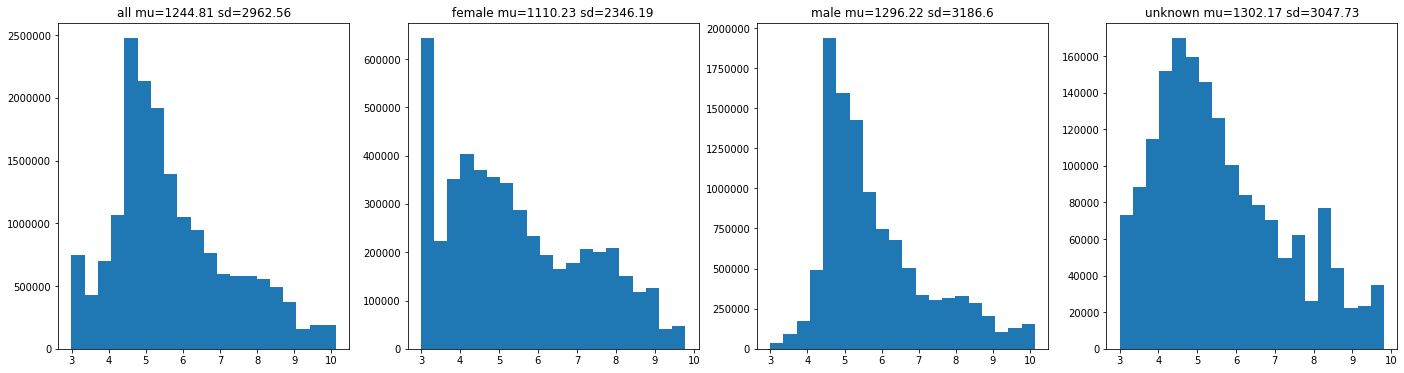

In [11]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

def get_title(name, df):
    mu = np.round(df["degree"].mean(), 2)
    sd = np.round(df["degree"].std(), 2)
    return f"{name} mu={mu} sd={sd}"

ax[0].hist(np.log(joined["degree"]), bins=20)
ax[0].set_title(get_title('all', joined))
ax[1].hist(np.log(female["degree"]), bins=20)
ax[1].set_title(get_title('female', female))
ax[2].hist(np.log(male["degree"]), bins=20)
ax[2].set_title(get_title('male', male))
ax[3].hist(np.log(unknown["degree"]), bins=20)
ax[3].set_title(get_title('unknown', unknown))

plt.show()

In [12]:
ratings_sub1 = ratings[ratings['source'] < 100]

In [15]:
ratings_sub1.to_csv('data/ratings_sub1.csv', index=False)

In [14]:
len(ratings_sub1)

13608

In [9]:
H = nx.from_pandas_edgelist(ratings_sub1, edge_attr=True)

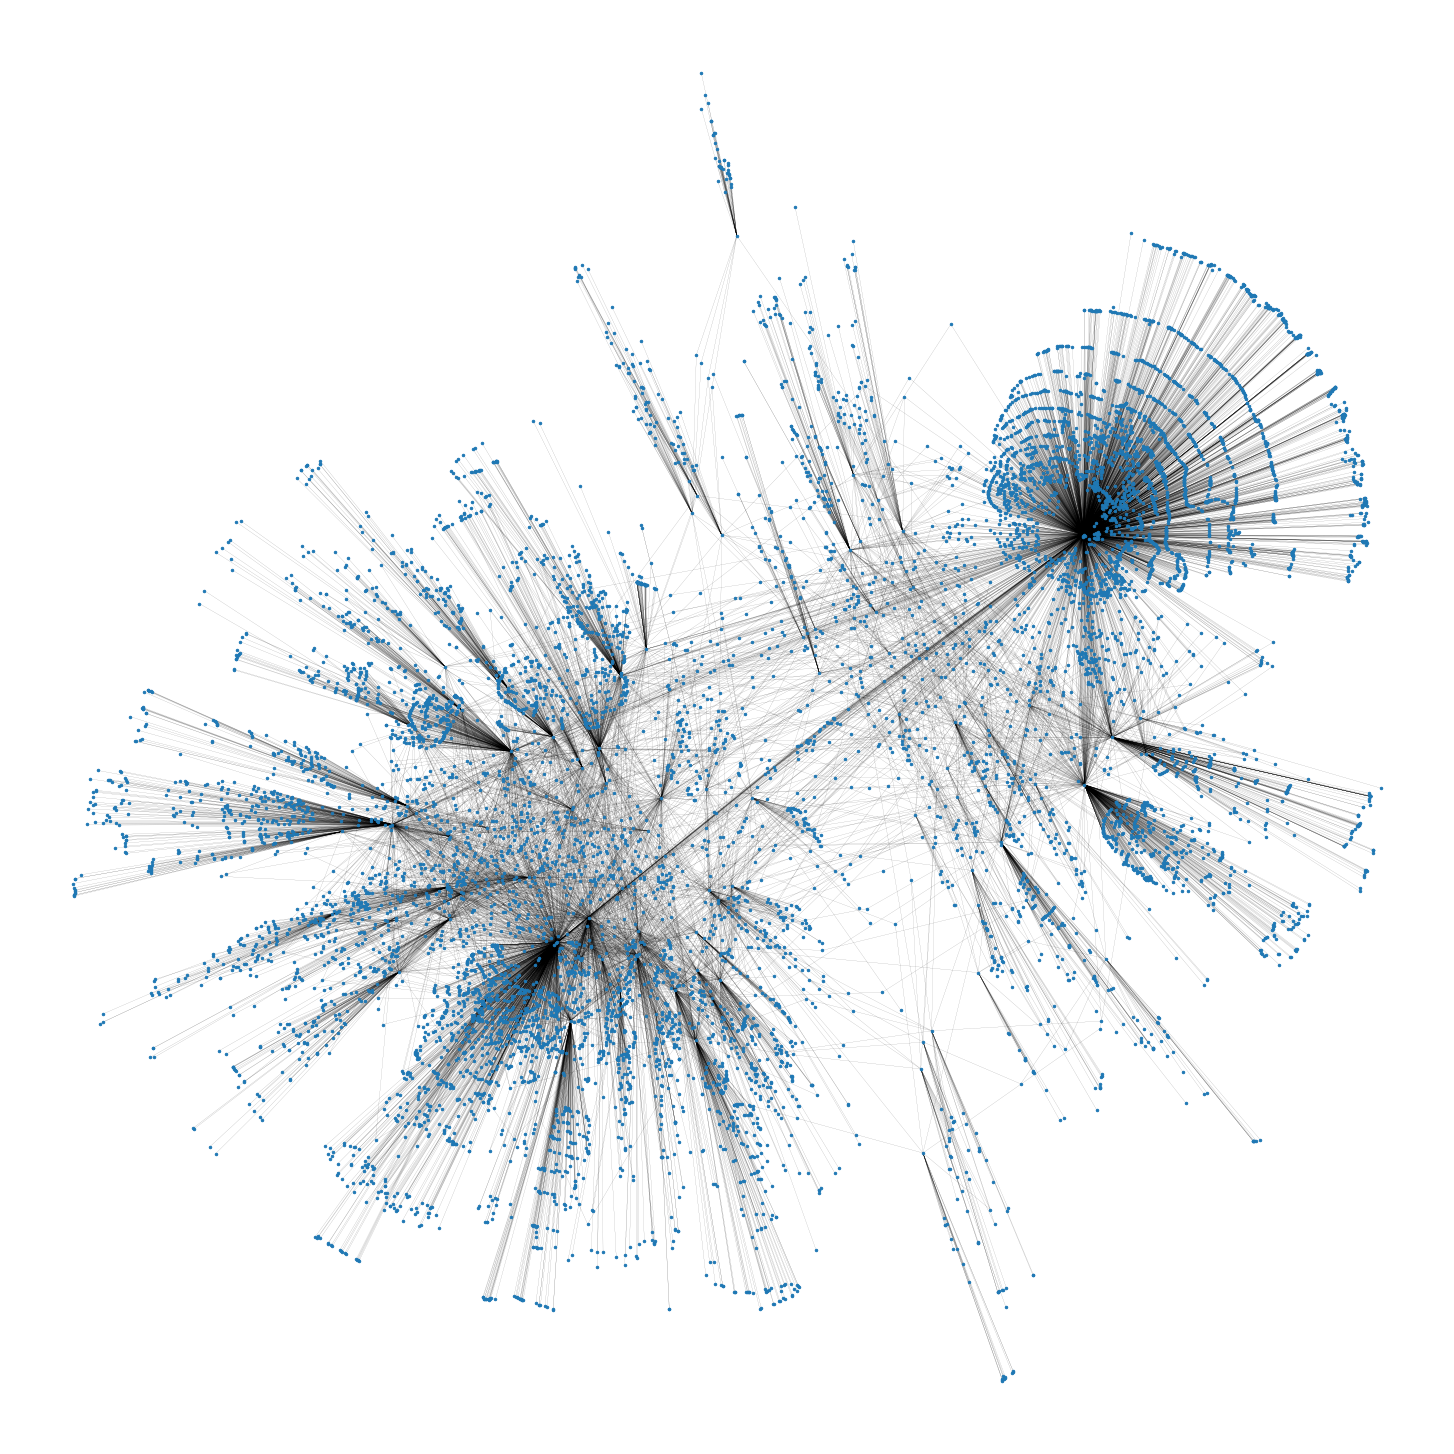

NameError: name 'savefig' is not defined

In [11]:
# Takes 5-10 minutes

plt.figure(3, figsize=(20,20)) 
nx.draw_spring(H, node_size=6, width=0.08)
plt.show()
plt.savefig('ratings_sub100.png')

In [ ]:
G = nx.from_pandas_edgelist(ratings, edge_attr=True)

In [20]:
G.edges(1)

EdgeDataView([(1, 133), (1, 720), (1, 971), (1, 1095), (1, 1616), (1, 1978), (1, 2145), (1, 2211), (1, 3751), (1, 4062), (1, 4633), (1, 4842), (1, 6518), (1, 7576), (1, 7724), (1, 8305), (1, 8923), (1, 9345), (1, 9729), (1, 10148), (1, 10811), (1, 11671), (1, 11747), (1, 12638), (1, 13210), (1, 13895), (1, 14205), (1, 14604), (1, 14985), (1, 15123), (1, 15408), (1, 15530), (1, 16480), (1, 18032), (1, 18287), (1, 18345), (1, 18444), (1, 18562), (1, 18878), (1, 19006), (1, 19231), (1, 19727), (1, 20253), (1, 20737), (1, 21184), (1, 21256), (1, 21642), (1, 22319), (1, 22543), (1, 22691), (1, 22853), (1, 22915), (1, 23036), (1, 23495), (1, 23499), (1, 24188), (1, 24294), (1, 24683), (1, 25731), (1, 26084), (1, 26236), (1, 26274), (1, 30417), (1, 32136), (1, 32953), (1, 33171), (1, 33205), (1, 33960), (1, 34358), (1, 34406), (1, 35647), (1, 35707), (1, 36750), (1, 37184), (1, 37773), (1, 38181), (1, 38356), (1, 38444), (1, 38648), (1, 38868), (1, 39095), (1, 39414), (1, 39520), (1, 39681), 

In [ ]:
G = graph
plt.figure(3,figsize=(20,20)) 
nx.draw_spring(G, node_size=6, width=0.08)
plt.show()

In [15]:
graph = nx.read_weighted_edgelist(PATH_RATINGS, delimiter = ",", create_using = nx.DiGraph())

KeyboardInterrupt: 

In [2]:
# loading graph from original file
def getGender(string_gender):
    if string_gender == "M\n":
        return "male"
    if string_gender == "F\n":
        return "female"
    else:
        return "unknown"



# loading edges + weight
graph = nx.read_weighted_edgelist(path_ratings, delimiter = ",", create_using = nx.DiGraph())

# loading node attributes
file_gender = open(path_gender, mode = "rt")
while True:
    new_line = file_gender.readline()
    if not new_line:
        break
    data = new_line.split(",")
    graph.nodes[data[0]]["gender"] = getGender(data[1])
file_gender.close()

KeyboardInterrupt: 

In [ ]:
print("nodes:", graph.number_of_nodes())
print("edges:", graph.number_of_edges())